In [62]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os

##############################################################################
# 1) CONFIGURE FILE PATHS & READ DATA
##############################################################################

data_dir = "../Data"  # <-- change if needed

gameData_path = os.path.join(data_dir, "gameData.csv")
rankData_path = os.path.join(data_dir, "rankData.csv")

# Read CSV files
games = pd.read_csv(gameData_path)
ranks = pd.read_csv(rankData_path)

##############################################################################
# 2) CREATE THE “STACKED” DATAFRAME
#    For each match, we produce TWO rows:
#      1) One from TeamA's perspective
#      2) One from TeamB's perspective
##############################################################################

rows_list = []

for idx, row in games.iterrows():
    # Basic match info
    year = row["Year"]
    teamA = row["TeamA"]
    teamB = row["TeamB"]
    goalsA = row["goalA"]
    goalsB = row["goalB"]
    home_val = row["Home"] if pd.notnull(row["Home"]) else ""  # could be 'A', 'B', or ''/NaN

    # 1) TeamA perspective
    #    Host = 1 if Home == 'A', else 0
    #    Neutral = 1 if neither A nor B is home (i.e. Home==''), else 0
    rows_list.append({
        "Year": year,
        "Team": teamA,
        "Opponent": teamB,
        "Goals": goalsA,
        "Host": 1 if home_val == "A" else 0,
        "Neutral": 1 if home_val == "" else 0
    })

    # 2) TeamB perspective
    rows_list.append({
        "Year": year,
        "Team": teamB,
        "Opponent": teamA,
        "Goals": goalsB,
        "Host": 1 if home_val == "B" else 0,
        "Neutral": 1 if home_val == "" else 0
    })

stacked_df = pd.DataFrame(rows_list)

##############################################################################
# 3) MERGE THE RANKINGS (FOR TEAM & OPPONENT) INTO THE STACKED DATA
#
#    We'll do TWO merges:
#    1) Merge 'Rank' for the focal team (Year,Team)
#    2) Merge 'Rank' again for the OPPONENT (Year,Opponent)
#
#    We'll rename columns to 'Rank_self' and 'Rank_opp' to distinguish them.
##############################################################################

# First merge: attach rank of the “Team”
stacked_df = pd.merge(
    stacked_df,
    ranks.rename(columns={"Team": "Team_merge", "Rank": "Rank_self"}),
    how="left",
    left_on=["Year", "Team"],
    right_on=["Year", "Team_merge"]
)

# Drop helper column 'Team_merge' if it exists
stacked_df.drop(columns=["Team_merge"], inplace=True)

# Second merge: attach rank of the “Opponent”
stacked_df = pd.merge(
    stacked_df,
    ranks.rename(columns={"Team": "Team_merge", "Rank": "Rank_opp"}),
    how="left",
    left_on=["Year", "Opponent"],
    right_on=["Year", "Team_merge"]
)

# Drop helper column 'Team_merge' if it exists
stacked_df.drop(columns=["Team_merge"], inplace=True)

# Now we have columns: 'Rank_self' and 'Rank_opp'

##############################################################################
# 4) FIT THE POISSON MODEL
#
#    Model: Goals ~ Rank_self + Rank_opp + Host + Neutral
##############################################################################

# In case there are any missing ranks (e.g., not found in rankData),
# you might want to drop rows with NaN in Rank_self or Rank_opp:
stacked_df = stacked_df.dropna(subset=["Rank_self", "Rank_opp"])

# Convert to numeric if needed
stacked_df["Rank_self"] = pd.to_numeric(stacked_df["Rank_self"], errors="coerce")
stacked_df["Rank_opp"] = pd.to_numeric(stacked_df["Rank_opp"], errors="coerce")
stacked_df["Goals"] = pd.to_numeric(stacked_df["Goals"], errors="coerce")

# Fit Poisson GLM
poisson_model = smf.glm(
    formula="Goals ~ Rank_self + Rank_opp + Host + Neutral",
    data=stacked_df,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())

##############################################################################
# 5) OPTIONAL CHECKS / PRINTING
##############################################################################

# Print the first few rows to verify structure
print("\n--- SAMPLE of stacked_df ---")
print(stacked_df)

# Print fitted coefficients
print("\n--- MODEL COEFFICIENTS ---")
print(poisson_model.params)



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                  514
Model:                            GLM   Df Residuals:                      509
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.13
Date:                Sun, 26 Jan 2025   Deviance:                       575.88
Time:                        21:24:32   Pearson chi2:                     486.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09583
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0471      0.169     -0.279      0.7

In [70]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import chi2

# -----------------------------------------------------------------------
# 1. Fit the Reduced Model
#    (Example: a Poisson model with fewer predictors)
# -----------------------------------------------------------------------
reduced_model = smf.glm(
    formula="Goals ~ Rank_self",  # Intercept only (no predictors)
    data=stacked_df,
    family=sm.families.Poisson()
).fit()

# -----------------------------------------------------------------------
# 2. Fit the Full Model
#    (Example: a Poisson model with all predictors of interest)
# -----------------------------------------------------------------------
full_model = smf.glm(
    formula="Goals ~ Rank_self + Rank_opp + Host + Neutral",
    data=stacked_df,
    family=sm.families.Poisson()
).fit()

# -----------------------------------------------------------------------
# 3. Compute the Likelihood Ratio
# -----------------------------------------------------------------------
logL_full = full_model.llf       # log-likelihood of the full model
logL_reduced = reduced_model.llf  # log-likelihood of the reduced model

LR_stat = 2 * (logL_full - logL_reduced)

# -----------------------------------------------------------------------
# 4. Degrees of Freedom
# -----------------------------------------------------------------------
df_full = full_model.df_model  # by default includes all parameters minus 1
df_reduced = reduced_model.df_model
df_diff = df_full - df_reduced  # difference in number of parameters

# Some versions: 
#   df_model returns #predictors, ignoring intercept. 
#   statsmodels also provides .params which includes intercept.
# Double-check how you want to handle the intercept, 
# but typically the difference in the # of parameters is what matters.

# -----------------------------------------------------------------------
# 5. p-value
# -----------------------------------------------------------------------
p_value = 1 - chi2.cdf(LR_stat, df_diff)

# -----------------------------------------------------------------------
# 6. Interpret the Results
# -----------------------------------------------------------------------
alpha = 0.05
print(f"Log-likelihood (full)    = {logL_full:.3f}")
print(f"Log-likelihood (reduced) = {logL_reduced:.3f}")
print(f"Likelihood Ratio (LR)    = {LR_stat:.3f}")
print(f"Degrees of Freedom (df)  = {df_diff}")
print(f"p-value                  = {p_value:.4f}")

if p_value < alpha:
    print("Reject the reduced model in favor of the full model (p < 0.05).")
else:
    print("Fail to reject the reduced model (p >= 0.05).")

Log-likelihood (full)    = -706.132
Log-likelihood (reduced) = -717.279
Likelihood Ratio (LR)    = 22.295
Degrees of Freedom (df)  = 3
p-value                  = 0.0001
Reject the reduced model in favor of the full model (p < 0.05).


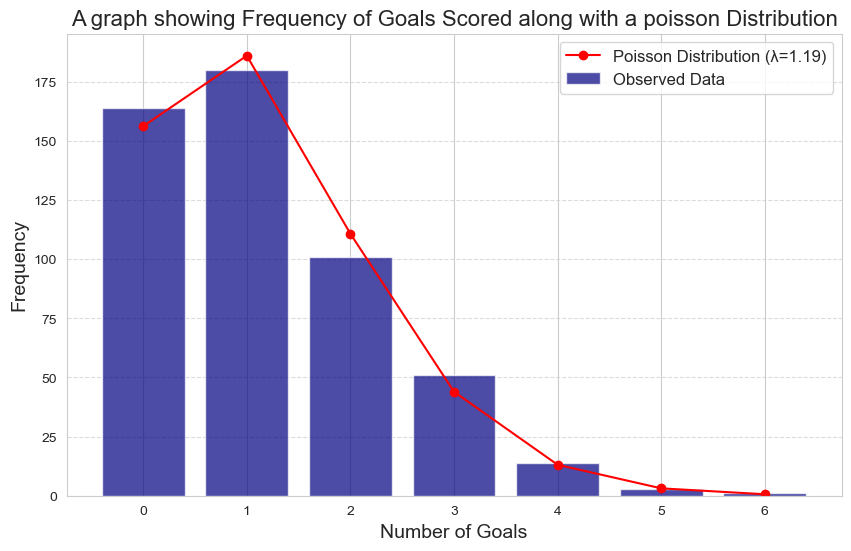

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.0002397209170452539

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import poisson

# Input data: List of goals
goals = [
    1, 0, 2, 2, 0, 4, 1, 1, 0, 1, 1, 2, 0, 1, 1, 3, 3, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 1, 
    1, 1, 2, 0, 0, 1, 2, 1, 3, 0, 0, 2, 3, 1, 0, 2, 1, 1, 0, 3, 0, 0, 4, 2, 3, 2, 0, 1, 2, 1, 
    0, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 2, 2, 1, 0, 3, 1, 1, 3, 4, 1, 2, 2, 0, 1, 1, 0, 0, 
    1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 3, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 2, 3, 1, 1, 
    0, 2, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 2, 1, 3, 2, 1, 0, 2, 3, 0, 0, 2, 1, 0, 1, 0, 0, 1, 2, 
    0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0, 
    1, 3, 0, 1, 1, 2, 1, 1, 3, 1, 1, 1, 0, 0, 1, 0, 4, 0, 2, 1, 1, 1, 2, 0, 2, 0, 3, 1, 1, 0, 
    0, 1, 2, 2, 2, 0, 3, 0, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 4, 1, 0, 1, 3, 1, 4, 2, 1, 1, 2, 5, 
    2, 2, 4, 0, 2, 0, 3, 3, 0, 1, 1, 2, 2, 4, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 3, 1, 2, 
    2, 2, 0, 3, 0, 1, 0, 1, 3, 0, 0, 0, 0, 2, 1, 0, 1, 1, 2, 1, 3, 1, 1, 3, 0, 3, 2, 0, 1, 0, 
    0, 1, 1, 0, 2, 2, 2, 3, 0, 3, 0, 2, 0, 2, 6, 1, 1, 0, 1, 1, 1, 0, 2, 0, 5, 2, 1, 1, 0, 3, 
    2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 2, 1, 3, 1, 0, 0, 3, 2, 0, 0, 0, 2, 0, 2, 0, 3, 4, 0, 1, 1, 
    2, 1, 1, 4, 1, 0, 2, 3, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 3, 0, 0, 1, 4, 0, 1, 1, 1, 1, 2, 1, 
    1, 2, 1, 1, 4, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 4, 2, 0, 0, 1, 4, 2, 0, 2, 1, 0, 1, 2, 1, 
    1, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 1, 1, 
    0, 2, 3, 0, 2, 1, 1, 3, 1, 5, 2, 0, 0, 0, 1, 0, 3, 1, 3, 3, 0, 1, 0, 0, 1, 0, 0, 3, 2, 1, 
    2, 1, 1, 0, 1, 2, 1, 1, 3, 0, 0, 1, 0, 3, 0, 3, 0, 2, 2, 0, 0, 0, 1, 3, 3, 2, 1, 1, 1, 1, 
    0, 1, 1, 1
]

# Count frequencies of goals
goal_counts = Counter(goals)
sorted_goal_counts = sorted(goal_counts.items())
x, y = zip(*sorted_goal_counts)

# Calculate Poisson parameters
lambda_poisson = np.mean(goals)
x_range = range(0, max(goals) + 1)
poisson_probs = [poisson.pmf(k, lambda_poisson) * len(goals) for k in x_range]

# Plot observed data and Poisson distribution
plt.figure(figsize=(10, 6))
plt.bar(x, y, alpha=0.7, color = "#000080", label='Observed Data')
plt.plot(x_range, poisson_probs, color = "#FF0000", marker='o', linestyle='-', label=f'Poisson Distribution (λ={lambda_poisson:.2f})')

# Add labels, title, and legend
plt.xlabel("Number of Goals", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("A graph showing Frequency of Goals Scored along with a poisson Distribution", fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f"/Users/ossianfinch/Downloads/Poisson Fit of Goals")
plt.show()

In [57]:
import math
from collections import Counter
import numpy as np
from scipy.stats import chi2

###############################################################################
# 1. Input data
###############################################################################
data = [
    1, 0, 2, 2, 0, 4, 1, 1, 0, 1, 1, 2, 0, 1, 1, 3, 3, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 0, 0, 1,
    1, 1, 2, 0, 0, 1, 2, 1, 3, 0, 0, 2, 3, 1, 0, 2, 1, 1, 0, 3, 0, 0, 4, 2, 3, 2, 0, 1, 2, 1,
    0, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 2, 2, 1, 0, 3, 1, 1, 3, 4, 1, 2, 2, 0, 1, 1, 0, 0,
    1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 3, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 2, 3, 1, 1,
    0, 2, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 2, 1, 3, 2, 1, 0, 2, 3, 0, 0, 2, 1, 0, 1, 0, 0, 1, 2,
    0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0,
    1, 3, 0, 1, 1, 2, 1, 1, 3, 1, 1, 1, 0, 0, 1, 0, 4, 0, 2, 1, 1, 1, 2, 0, 2, 0, 3, 1, 1, 0,
    0, 1, 2, 2, 2, 0, 3, 0, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 4, 1, 0, 1, 3, 1, 4, 2, 1, 1, 2, 5,
    2, 2, 4, 0, 2, 0, 3, 3, 0, 1, 1, 2, 2, 4, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 3, 1, 2,
    2, 2, 0, 3, 0, 1, 0, 1, 3, 0, 0, 0, 0, 2, 1, 0, 1, 1, 2, 1, 3, 1, 1, 3, 0, 3, 2, 0, 1, 0,
    0, 1, 1, 0, 2, 2, 2, 3, 0, 3, 0, 2, 0, 2, 6, 1, 1, 0, 1, 1, 1, 0, 2, 0, 5, 2, 1, 1, 0, 3,
    2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 2, 1, 3, 1, 0, 0, 3, 2, 0, 0, 0, 2, 0, 2, 0, 3, 4, 0, 1, 1,
    2, 1, 1, 4, 1, 0, 2, 3, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 3, 0, 0, 1, 4, 0, 1, 1, 1, 1, 2, 1,
    1, 2, 1, 1, 4, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 4, 2, 0, 0, 1, 4, 2, 0, 2, 1, 0, 1, 2, 1,
    1, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 2, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 1, 1,
    0, 2, 3, 0, 2, 1, 1, 3, 1, 5, 2, 0, 0, 0, 1, 0, 3, 1, 3, 3, 0, 1, 0, 0, 1, 0, 0, 3, 2, 1,
    2, 1, 1, 0, 1, 2, 1, 1, 3, 0, 0, 1, 0, 3, 0, 3, 0, 2, 2, 0, 0, 0, 1, 3, 3, 2, 1, 1, 1, 1,
    0, 1, 1, 1
]

# Number of observations
n = len(data)
print("Total observations (n) =", n)

###############################################################################
# 2. Count data in each bin: {0}, {1}, {2}, {3}, {>= 4}
###############################################################################
counts = Counter(data)

obs_0 = counts[0]
obs_1 = counts[1]
obs_2 = counts[2]
obs_3 = counts[3]

# Everything 4 or above lumps into one bin
obs_4plus = sum(counts[k] for k in counts if k >= 4)

print("Observed counts in bin 0:", obs_0)
print("Observed counts in bin 1:", obs_1)
print("Observed counts in bin 2:", obs_2)
print("Observed counts in bin 3:", obs_3)
print("Observed counts in bin >=4:", obs_4plus)

###############################################################################
# 3. Compute expected counts for each bin under Poisson(lambda=1.19)
###############################################################################
lam = 1.19

def poisson_pmf(k, lam):
    return math.exp(-lam) * lam**k / math.factorial(k)

# Probability of X=0, X=1, X=2, X=3 under Poisson(1.19)
p_0 = poisson_pmf(0, lam)
p_1 = poisson_pmf(1, lam)
p_2 = poisson_pmf(2, lam)
p_3 = poisson_pmf(3, lam)

# Probability of X >= 4 = 1 - (p_0 + p_1 + p_2 + p_3)
p_4plus = 1.0 - (p_0 + p_1 + p_2 + p_3)

# Expected frequencies for each bin
exp_0 = n * p_0
exp_1 = n * p_1
exp_2 = n * p_2
exp_3 = n * p_3
exp_4plus = n * p_4plus

print("\nExpected counts under Poisson(1.19):")
print(f"Bin 0: {exp_0:.3f}")
print(f"Bin 1: {exp_1:.3f}")
print(f"Bin 2: {exp_2:.3f}")
print(f"Bin 3: {exp_3:.3f}")
print(f"Bin >=4: {exp_4plus:.3f}")

###############################################################################
# 4. Chi-square test
###############################################################################
# We have 5 bins in total => degrees of freedom = (#bins - 1) = 4,
# assuming lambda=1.19 is fixed (not estimated from this same dataset).
observed = np.array([obs_0, obs_1, obs_2, obs_3, obs_4plus], dtype=float)
expected = np.array([exp_0, exp_1, exp_2, exp_3, exp_4plus], dtype=float)

chi_square = np.sum((observed - expected)**2 / expected)
df = 4  # as specified
p_value = 1 - chi2.cdf(chi_square, df)

print("\nChi-square statistic =", chi_square)
print("Degrees of freedom   =", df)
print("p-value             =", p_value)

###############################################################################
# 5. Hypothesis test at 5% significance
###############################################################################
alpha = 0.05
if p_value < alpha:
    print(f"Since p-value < {alpha}, we reject the null hypothesis.")
    print("Conclusion: Data do NOT appear to follow Poisson(1.19) at the 5% level.")
else:
    print(f"Since p-value >= {alpha}, we fail to reject the null hypothesis.")
    print("Conclusion: Data are consistent with Poisson(1.19) at the 5% level.")

Total observations (n) = 514
Observed counts in bin 0: 164
Observed counts in bin 1: 180
Observed counts in bin 2: 101
Observed counts in bin 3: 51
Observed counts in bin >=4: 18

Expected counts under Poisson(1.19):
Bin 0: 156.370
Bin 1: 186.080
Bin 2: 110.718
Bin 3: 43.918
Bin >=4: 16.915

Chi-square statistic = 2.635539869258094
Degrees of freedom   = 4
p-value             = 0.6205404753128253
Since p-value >= 0.05, we fail to reject the null hypothesis.
Conclusion: Data are consistent with Poisson(1.19) at the 5% level.


In [10]:
import os
import pandas as pd
import math
import random
import numpy as np
from scipy.stats import poisson
from collections import defaultdict

try:
    from tqdm import trange
except ImportError:
    print("tqdm not installed. You won't see a progress bar.")
    def trange(*args, **kwargs):
        return range(*args)

###############################################################################
# 1) CONFIG AND DATA
###############################################################################

# Poisson model parameters (from your GLM)
COEF_INTERCEPT = -0.0471
COEF_RANK_SELF = -0.0183
COEF_RANK_OPP  =  0.0088
COEF_HOST      =  0.6451
COEF_NEUTRAL   =  0.3524

# The 24 teams, grouped as specified:
GROUPS = {
    "A": ["Germany", "Switzerland", "Hungary", "Scotland"],
    "B": ["Spain", "Italy", "Croatia", "Albania"],
    "C": ["England", "Denmark", "Slovenia", "Serbia"],
    "D": ["Austria", "France", "Netherlands", "Poland"],
    "E": ["Romania", "Belgium", "Slovakia", "Ukraine"],
    "F": ["Portugal", "Turkey", "Georgia", "Czech Republic"]
}


# Load ranking data: "2024_rankings.csv" must have columns ["Team", "Rank"].
data_dir = "../Data"
ranks2024_path = os.path.join(data_dir, "2024_rankings.csv")
ranks_df = pd.read_csv(ranks2024_path)
rank_dict = dict(zip(ranks_df["Team"], ranks_df["Rank"]))

# Verify that all teams in GROUPS are in rank_dict:
all_teams = set()
for group_teams in GROUPS.values():
    all_teams.update(group_teams)

if len(all_teams) != 24:
    raise ValueError("Expected exactly 24 unique teams in the groups!")

for t in all_teams:
    if t not in rank_dict:
        raise ValueError(f"Team '{t}' is missing from 2024_rankings.csv!")

def save_estimates_to_csv(df, filepath="prob_estimates.csv"):
    """
    Save the probability estimates DataFrame (including CIs) to a CSV file.
    """
    df.to_csv(filepath, index=False)
    print(f"Probability estimates (including CIs) have been saved to '{filepath}'.")

###############################################################################
# 2) HELPERS: POISSON MATCH SIMULATION + KNOCKOUT EXTRAS
###############################################################################

def clamp_rate(x):
    """
    Avoid passing ~0 or negative to poisson.rvs by clamping small or non-finite.
    """
    lam = math.exp(x)
    if lam < 1e-9 or not np.isfinite(lam):
        lam = 1e-9
    return lam

def match_log_rates_90(rankA, rankB, AHost=0, BHost=0, Neutral=1):
    """
    Returns (logLamA_90, logLamB_90), the log of the 90-min rates for each side,
    using the GLM coefficients.
    """
    xA_90 = (COEF_INTERCEPT
             + COEF_RANK_SELF*rankA
             + COEF_RANK_OPP*rankB
             + COEF_HOST*AHost
             + COEF_NEUTRAL*Neutral)

    xB_90 = (COEF_INTERCEPT
             + COEF_RANK_SELF*rankB
             + COEF_RANK_OPP*rankA
             + COEF_HOST*BHost
             + COEF_NEUTRAL*Neutral)
    return xA_90, xB_90

def play_match_90(rankA, rankB, AHost=0, BHost=0, Neutral=1, minutes=90):
    """
    Simulate a match using the Poisson model for 'minutes' (default 90).
    """
    scale = minutes / 90.0
    xA_90, xB_90 = match_log_rates_90(rankA, rankB, AHost, BHost, Neutral)
    xA = xA_90 + math.log(scale)
    xB = xB_90 + math.log(scale)

    lamA = clamp_rate(xA)
    lamB = clamp_rate(xB)

    gA = poisson.rvs(lamA)
    gB = poisson.rvs(lamB)
    return gA, gB

def play_knockout_match(rankA, rankB, AHost=0, BHost=0, Neutral=1):
    """
    Knockout style match with potential extra time:
      1) 90 min
      2) If tied -> 30 min
      3) If still tied -> penalty (50-50).
    Returns (final_goalsA, final_goalsB, winner='A' or 'B').
    """
    # 90 min
    gA_reg, gB_reg = play_match_90(rankA, rankB, AHost, BHost, Neutral, minutes=90)
    if gA_reg != gB_reg:
        return gA_reg, gB_reg, ('A' if gA_reg > gB_reg else 'B')

    # Extra time (30)
    gA_et, gB_et = play_match_90(rankA, rankB, AHost, BHost, Neutral, minutes=30)
    A_total = gA_reg + gA_et
    B_total = gB_reg + gB_et
    if A_total != B_total:
        return A_total, B_total, ('A' if A_total > B_total else 'B')

    # Penalties (50-50)
    winner = 'A' if random.random() < 0.5 else 'B'
    return A_total, B_total, winner

###############################################################################
# 3) MOST LIKELY SINGLE MATCH OUTCOME
###############################################################################
def most_likely_score_90(rankA, rankB, AHost=0, BHost=0, Neutral=1):
    """
    Returns (goalsA, goalsB) that has the single highest probability
    in the 2D distribution of (A_goals, B_goals) up to 7 goals each side.
    """
    xA_90, xB_90 = match_log_rates_90(rankA, rankB, AHost, BHost, Neutral)
    lamA = clamp_rate(xA_90)
    lamB = clamp_rate(xB_90)

    best_score = (0,0)
    best_prob = 0.0
    for gA in range(8):
        for gB in range(8):
            pA = (lamA**gA)*math.exp(-lamA)/math.factorial(gA)
            pB = (lamB**gB)*math.exp(-lamB)/math.factorial(gB)
            prob = pA * pB
            if prob > best_prob:
                best_prob = prob
                best_score = (gA, gB)

    return best_score

def most_likely_knockout_winner(rankA, rankB, AHost=0, BHost=0, Neutral=1):
    """
    Returns which side ('A' or 'B') is *overall* most likely to eventually win
    in a knockout (including the possibility of extra time).
    We approximate by enumerating 90-min results. Ties => 50-50 in final outcome.
    """
    xA_90, xB_90 = match_log_rates_90(rankA, rankB, AHost, BHost, Neutral)
    lamA = clamp_rate(xA_90)
    lamB = clamp_rate(xB_90)

    pA_wins = 0.0
    pB_wins = 0.0
    for gA in range(8):
        for gB in range(8):
            pA = (lamA**gA)*math.exp(-lamA)/math.factorial(gA)
            pB = (lamB**gB)*math.exp(-lamB)/math.factorial(gB)
            prob = pA * pB
            if gA > gB:
                pA_wins += prob
            elif gB > gA:
                pB_wins += prob
            else:
                # tie => half chance each
                pA_wins += 0.5 * prob
                pB_wins += 0.5 * prob

    return 'A' if (pA_wins >= pB_wins) else 'B'


###############################################################################
# 4) GROUP STAGE (RANDOM VS MOST-LIKELY) & KNOCKOUT ROUND
###############################################################################

def simulate_group_stage_random(groups_dict):
    """
    Random simulation of the group stage:
     - Each match is random (Poisson).
     - Sort by Points, GD, GF, random fallback
    """
    standings = {}
    for g, team_list in groups_dict.items():
        data = {
            "Team": team_list,
            "Points": [0]*4,
            "GF": [0]*4,
            "GA": [0]*4
        }
        df_g = pd.DataFrame(data)
        for i in range(4):
            for j in range(i+1, 4):
                Ateam = df_g.loc[i, "Team"]
                Bteam = df_g.loc[j, "Team"]
                rankA = rank_dict[Ateam]
                rankB = rank_dict[Bteam]
                gA, gB = play_match_90(rankA, rankB)
                df_g.loc[i, "GF"] += gA
                df_g.loc[i, "GA"] += gB
                df_g.loc[j, "GF"] += gB
                df_g.loc[j, "GA"] += gA

                if gA > gB:
                    df_g.loc[i, "Points"] += 3
                elif gB > gA:
                    df_g.loc[j, "Points"] += 3
                else:
                    df_g.loc[i, "Points"] += 1
                    df_g.loc[j, "Points"] += 1

        df_g["GD"] = df_g["GF"] - df_g["GA"]
        df_g["tiebreak"] = [random.random() for _ in range(4)]
        df_g = df_g.sort_values(
            by=["Points","GD","GF","tiebreak"],
            ascending=[False,False,False,False]
        ).reset_index(drop=True)
        df_g.drop(columns=["tiebreak"], inplace=True)
        standings[g] = df_g
    return standings

def simulate_group_stage_most_likely(groups_dict):
    """
    Deterministic group stage: each match picks the single most-likely score.
    """
    standings = {}
    for g, team_list in groups_dict.items():
        data = {
            "Team": team_list,
            "Points": [0]*4,
            "GF": [0]*4,
            "GA": [0]*4
        }
        df_g = pd.DataFrame(data)
        for i in range(4):
            for j in range(i+1, 4):
                Ateam = df_g.loc[i, "Team"]
                Bteam = df_g.loc[j, "Team"]
                rankA = rank_dict[Ateam]
                rankB = rank_dict[Bteam]
                gA, gB = most_likely_score_90(rankA, rankB)
                df_g.loc[i, "GF"] += gA
                df_g.loc[i, "GA"] += gB
                df_g.loc[j, "GF"] += gB
                df_g.loc[j, "GA"] += gA

                if gA > gB:
                    df_g.loc[i, "Points"] += 3
                elif gB > gA:
                    df_g.loc[j, "Points"] += 3
                else:
                    df_g.loc[i, "Points"] += 1
                    df_g.loc[j, "Points"] += 1

        df_g["GD"] = df_g["GF"] - df_g["GA"]
        # break ties by alphabetical as last fallback
        df_g = df_g.sort_values(
            by=["Points","GD","GF","Team"],
            ascending=[False,False,False,True]
        ).reset_index(drop=True)
        standings[g] = df_g
    return standings

def pick_knockout_teams(standings, randomize_ties=True):
    """
    From each group, take top 2 + the 4 best third-placed sides.
    If randomize_ties=True, we shuffle third-place ties.
    """
    qualified = []
    third_rows = []

    for g, df_g in standings.items():
        qualified.append(df_g.loc[0, "Team"])
        qualified.append(df_g.loc[1, "Team"])
        row3 = df_g.loc[2].copy()
        row3["Group"] = g
        third_rows.append(row3)

    df_third = pd.DataFrame(third_rows)
    if randomize_ties:
        df_third["tiebreak"] = [random.random() for _ in range(len(df_third))]
        df_third = df_third.sort_values(
            by=["Points","GD","GF","tiebreak"],
            ascending=[False,False,False,False]
        )
    else:
        df_third = df_third.sort_values(
            by=["Points","GD","GF","Team"],
            ascending=[False,False,False,True]
        )

    best4 = df_third.head(4)["Team"].tolist()
    qualified.extend(best4)
    return qualified

def knockout_round_random(team_list):
    """
    In random mode: shuffle the team_list, pair them, simulate knockout.
    """
    random.shuffle(team_list)
    winners = []
    for i in range(0, len(team_list), 2):
        if i+1 >= len(team_list):
            winners.append(team_list[i])
            continue
        Ateam = team_list[i]
        Bteam = team_list[i+1]
        rA = rank_dict[Ateam]
        rB = rank_dict[Bteam]
        gA, gB, w_side = play_knockout_match(rA, rB)
        winners.append(Ateam if w_side=='A' else Bteam)
    return winners

def knockout_round_most_likely(team_list):
    """
    Deterministic knockout: pair teams in order and pick the "most likely" winner.
    """
    winners = []
    for i in range(0, len(team_list), 2):
        if i+1 >= len(team_list):
            winners.append(team_list[i])
            continue
        Ateam = team_list[i]
        Bteam = team_list[i+1]
        rA = rank_dict[Ateam]
        rB = rank_dict[Bteam]
        w_side = most_likely_knockout_winner(rA, rB)
        winners.append(Ateam if w_side=='A' else Bteam)
    return winners

###############################################################################
# 5) TOURNAMENT SIMULATION MODES
###############################################################################

def random_simulate_tournament():
    """Simulate entire tournament in a random/Monte Carlo style."""
    gs = simulate_group_stage_random(GROUPS)
    teams16 = pick_knockout_teams(gs, randomize_ties=True)
    r16_winners = knockout_round_random(teams16)
    qf_winners = knockout_round_random(r16_winners)
    sf_winners = knockout_round_random(qf_winners)
    final_winners = knockout_round_random(sf_winners)
    champion = final_winners[0] if final_winners else None

    return {
        "GroupStage": gs,
        "R16": r16_winners,
        "QF": qf_winners,
        "SF": sf_winners,
        "F": final_winners,
        "Champion": champion
    }

def most_likely_tournament():
    """Deterministic bracket from start to finish."""
    gs = simulate_group_stage_most_likely(GROUPS)
    teams16 = pick_knockout_teams(gs, randomize_ties=False)
    r16_winners = knockout_round_most_likely(teams16)
    qf_winners = knockout_round_most_likely(r16_winners)
    sf_winners = knockout_round_most_likely(qf_winners)
    final_winners = knockout_round_most_likely(sf_winners)
    champion = final_winners[0] if final_winners else None

    return {
        "GroupStage": gs,
        "R16": r16_winners,
        "QF": qf_winners,
        "SF": sf_winners,
        "F": final_winners,
        "Champion": champion
    }

###############################################################################
# 6) RUN MULTIPLE SIMS & PARAMETRIC BOOTSTRAP
###############################################################################

def run_many_simulations(n_sims=1000):
    """
    Runs random_simulate_tournament() n_sims times.
    Tracks how often each team reaches R16, QF, SF, F, and Champion.
    Returns a DataFrame with columns:
      Team, p_R16, p_QF, p_SF, p_F, p_Ch
    (We'll do the parametric bootstrap separately in param_bootstrap_CI.)
    """
    stage_counts = defaultdict(lambda: {"R16":0, "QF":0, "SF":0, "F":0, "Ch":0})

    for _ in trange(n_sims, desc="Simulating"):
        res = random_simulate_tournament()

        for t in res["R16"]:
            stage_counts[t]["R16"] += 1
        for t in res["QF"]:
            stage_counts[t]["QF"] += 1
        for t in res["SF"]:
            stage_counts[t]["SF"] += 1
        for t in res["F"]:
            stage_counts[t]["F"] += 1
        c = res["Champion"]
        if c:
            stage_counts[c]["Ch"] += 1

    # Convert counts to proportions
    rows = []
    for t in sorted(all_teams):
        c = stage_counts[t]
        p_r16 = c["R16"]/n_sims
        p_qf  = c["QF"]/n_sims
        p_sf  = c["SF"]/n_sims
        p_f   = c["F"]/n_sims
        p_ch  = c["Ch"]/n_sims

        rows.append({
            "Team": t,
            "p_R16": p_r16,
            "p_QF": p_qf,
            "p_SF": p_sf,
            "p_F":  p_f,
            "p_Ch": p_ch
        })

    return pd.DataFrame(rows)


def param_bootstrap_CI(df_probs, n_sims=1000, B=1000, alpha=0.95):
    """
    Given the "df_probs" from run_many_simulations, which has columns like:
      Team, p_R16, p_QF, p_SF, p_F, p_Ch
    we do a parametric bootstrap for each p_Stage by:
      - generating binomial(N, p_Stage) B times => p_star
      - computing the percentile-based confidence intervals.

    :param n_sims: the original number of sims used to produce the estimates
    :param B: number of bootstrap replicates
    :param alpha: coverage probability (default 0.95)
    :return: same DataFrame but with added columns for [stage]_low, [stage]_high
    """
    lower_q = (1 - alpha)/2
    upper_q = 1 - lower_q

    # We'll store all intervals in new columns
    out_df = df_probs.copy()

    stages = ["R16", "QF", "SF", "F", "Ch"]
    for stage in stages:
        low_col = f"p_{stage}_low"
        high_col = f"p_{stage}_high"
        out_df[low_col] = np.nan
        out_df[high_col] = np.nan

    for i, row in out_df.iterrows():
        for stage in stages:
            p_hat = row[f"p_{stage}"]
            # parametric bootstrap: X ~ Binomial(n_sims, p_hat)
            # do B replicates
            draws = np.random.binomial(n_sims, p_hat, size=B) / n_sims
            ci_low = np.quantile(draws, lower_q)
            ci_high = np.quantile(draws, upper_q)
            out_df.loc[i, f"p_{stage}_low"] = ci_low
            out_df.loc[i, f"p_{stage}_high"] = ci_high

    return out_df


###############################################################################
# 7) MAIN DEMO
###############################################################################
if __name__ == "__main__":
    # 1) Single run of N tournaments to get probabilities
    N = 100000
    df_est = run_many_simulations(n_sims=N)

    # 2) Compute parametric bootstrap CIs
    B = 1000  # number of bootstrap resamples
    df_boot = param_bootstrap_CI(df_est, n_sims=N, B=B, alpha=0.95)

    # 3) Print results with CIs (sorted by p_Ch desc)
    df_boot.sort_values("p_Ch", ascending=False, inplace=True)
    print(f"\n=== Probability Estimates & 95% Parametric CI (N={N} sims, B={B} bootstrap) ===")
    cols_show = ["Team",
                 "p_R16", "p_R16_low", "p_R16_high",
                 "p_QF", "p_QF_low", "p_QF_high",
                 "p_SF", "p_SF_low", "p_SF_high",
                 "p_F",  "p_F_low",  "p_F_high",
                 "p_Ch","p_Ch_low","p_Ch_high"]
    print(df_boot[cols_show].to_string(index=False, float_format=lambda x: f"{x:0.4f}"))
    # Optionally, save to CSV
    save_estimates_to_csv(df_boot[cols_show], filepath="/Users/ossianfinch/Downloads/prob_estimates.csv")

    # 4) Most likely bracket (deterministic)
    ml_res = most_likely_tournament()
    print("\n=== MOST LIKELY GROUP-STAGE RESULTS ===")
    for g in sorted(ml_res["GroupStage"].keys()):
        print(f"\nGroup {g}:")
        df_g = ml_res["GroupStage"][g]
        print(df_g[["Team","Points","GF","GA","GD"]].to_string(index=False))

    print("\n=== MOST LIKELY KNOCKOUT STAGES ===")
    print("Round of 16 Teams:", ml_res["R16"])
    print("Quarterfinal winners:", ml_res["QF"])
    print("Semifinal winners:", ml_res["SF"])
    print("Finalists:", ml_res["F"])
    print("Champion:", ml_res["Champion"])

Simulating: 100%|██████████| 100000/100000 [34:33<00:00, 48.23it/s]


=== Probability Estimates & 95% Parametric CI (N=100000 sims, B=1000 bootstrap) ===
          Team  p_R16  p_R16_low  p_R16_high   p_QF  p_QF_low  p_QF_high   p_SF  p_SF_low  p_SF_high    p_F  p_F_low  p_F_high   p_Ch  p_Ch_low  p_Ch_high
       Belgium 0.6212     0.6184      0.6240 0.3854    0.3823     0.3885 0.2284    0.2256     0.2310 0.1310   0.1288    0.1331 0.1310    0.1289     0.1331
        France 0.5668     0.5636      0.5697 0.3539    0.3510     0.3569 0.2140    0.2116     0.2165 0.1253   0.1233    0.1272 0.1253    0.1232     0.1273
       England 0.5976     0.5948      0.6007 0.3632    0.3602     0.3662 0.2122    0.2097     0.2145 0.1192   0.1173    0.1212 0.1192    0.1172     0.1212
      Portugal 0.5996     0.5968      0.6027 0.3501    0.3472     0.3531 0.1974    0.1949     0.1997 0.1070   0.1052    0.1090 0.1070    0.1053     0.1090
         Spain 0.5327     0.5295      0.5357 0.2999    0.2967     0.3028 0.1610    0.1587     0.1635 0.0832   0.0815    0.0849 0.0832    0.0

/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_95082/3733440577.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


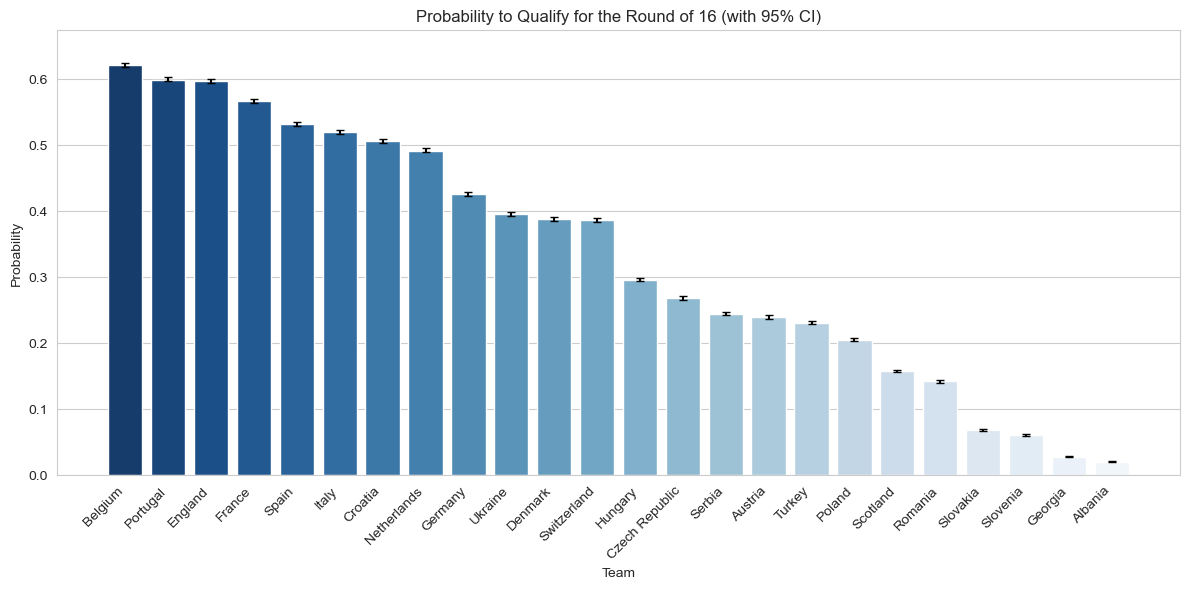

/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_95082/3733440577.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


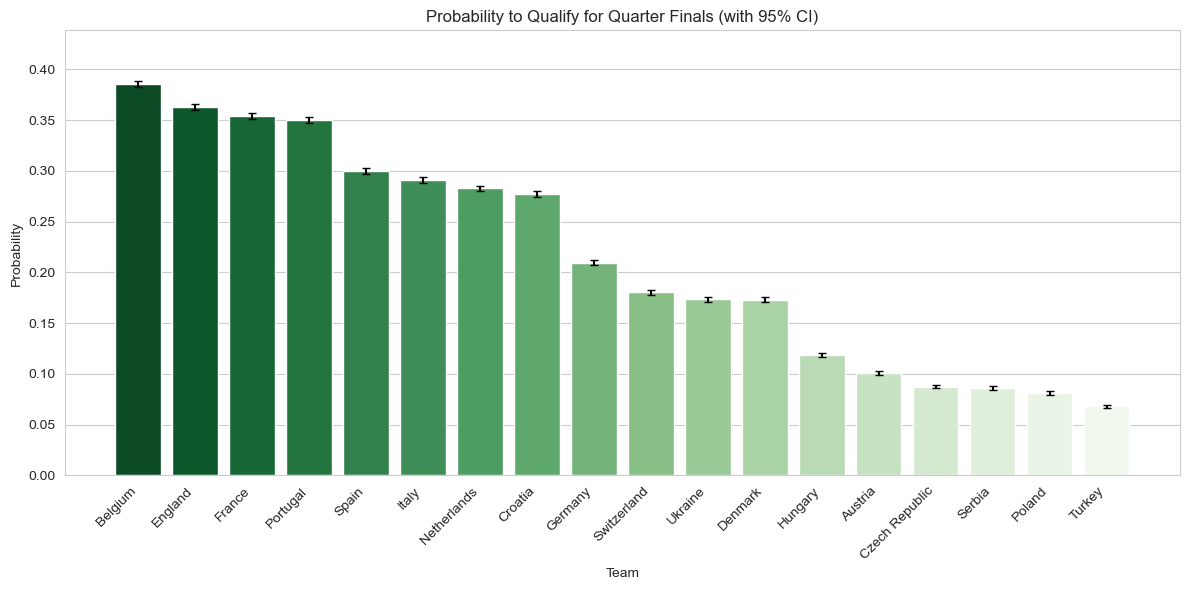

/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_95082/3733440577.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


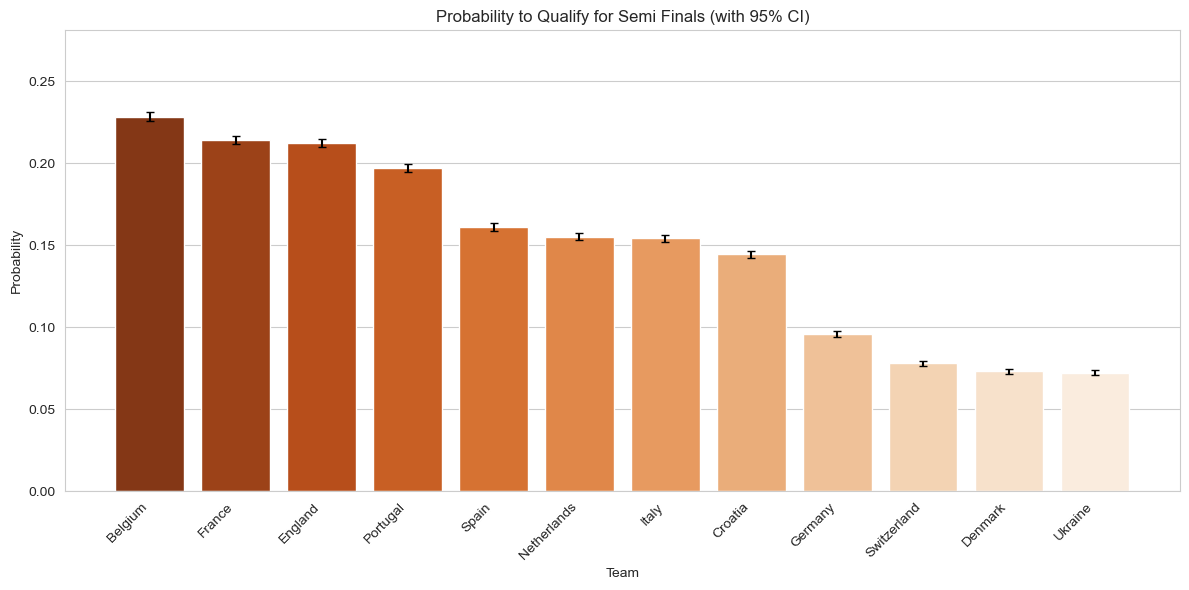

/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_95082/3733440577.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


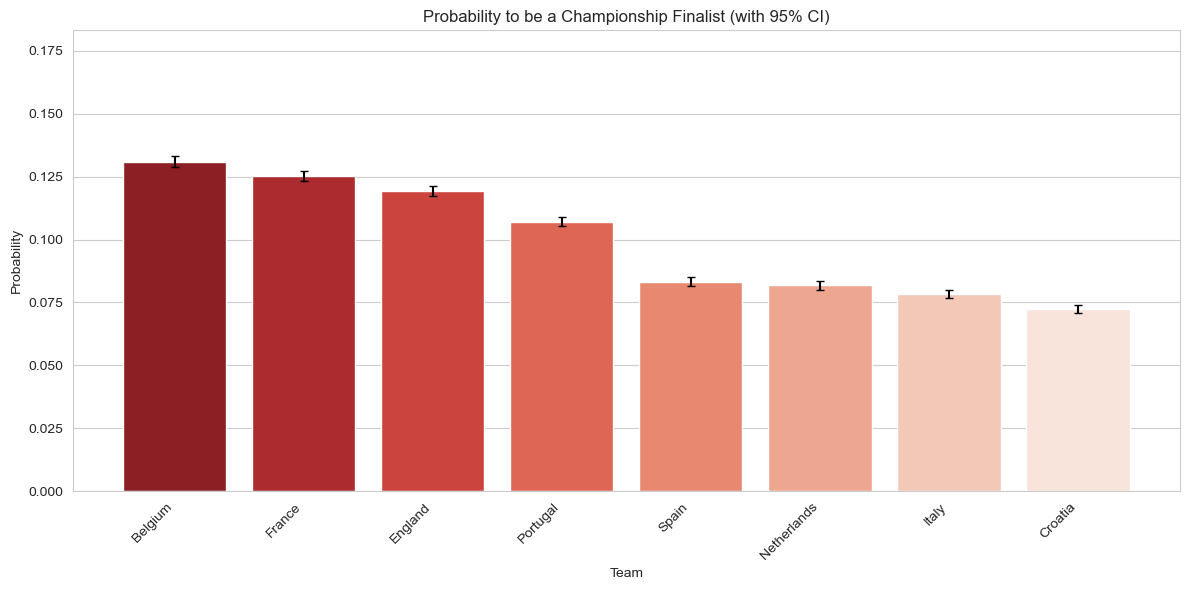

/var/folders/xw/rtnxpqfs5x1c24fnd80jdymh0000gn/T/ipykernel_95082/3733440577.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


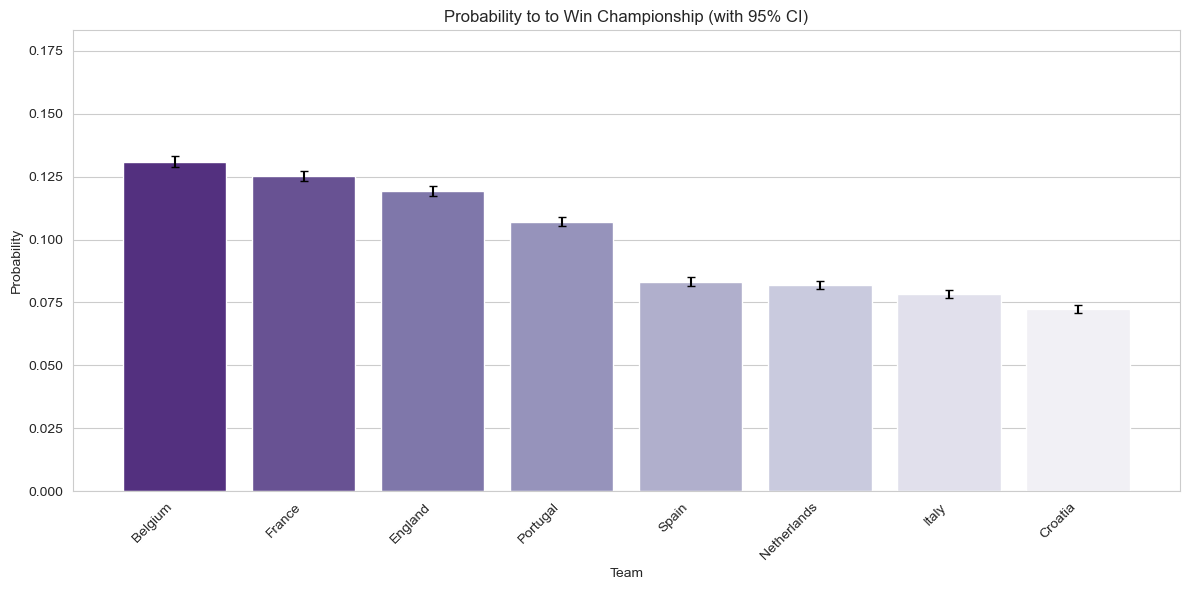

In [18]:
#!/usr/bin/env python3

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make plots look a bit nicer
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# -------------------------------------------------------------------------
# 1. Create the DataFrame with your full dataset
# -------------------------------------------------------------------------
df = df_boot
# -------------------------------------------------------------------------
# 2. Reshape the DataFrame to a "long" format
# -------------------------------------------------------------------------
stages = ["R16", "QF", "SF", "F", "Ch"]
records = []

for _, row in df.iterrows():
    team = row["Team"]
    for stage in stages:
        # Probability columns
        p_col = f"p_{stage}"
        p_low_col = f"{p_col}_low"
        p_high_col = f"{p_col}_high"
        records.append({
            "Team": team,
            "Stage": stage,
            "prob": row[p_col],
            "prob_low": row[p_low_col],
            "prob_high": row[p_high_col]
        })

df_long = pd.DataFrame(records)

# -------------------------------------------------------------------------
# 3. (Optional) Group by (Team, Stage) to ensure one record per group
#    (We do have exactly one row for each combination, but let's do it
#    explicitly. This also helps us match indices when passing yerr.)
# -------------------------------------------------------------------------
agg = (
    df_long
    .groupby(["Team", "Stage"], as_index=False)  # no aggregator needed
    .mean(numeric_only=True)                     # just keep the single row
)

# Compute symmetrical error bars
agg["err_low"] = agg["prob"] - agg["prob_low"]
agg["err_high"] = agg["prob_high"] - agg["prob"]

# -------------------------------------------------------------------------
# 4. Plot A: Grouped bar plot (Teams on x-axis, Stage as hue)
#    Using the new "errorbar=None" style.
# -------------------------------------------------------------------------
# Compute symmetrical error bars
agg["yerr_low"] = agg["prob"] - agg["prob_low"]
agg["yerr_high"] = agg["prob_high"] - agg["prob"]

# Define a function to create a plot for a single stage
def plot_stage(stage, data, title, palette_base):
    # Sort data by probability to assign colors consistently
    data = data.sort_values(by="prob", ascending=False).reset_index(drop=True)
    
    # Create a gradient color palette based on probabilities, reversed for darkest = highest
    palette = sns.color_palette(palette_base, len(data))[::-1]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data,
        x="Team",
        y="prob",
        hue=None,  # No hue needed since we're plotting a single stage
        palette=palette,  # Use reversed gradient palette
        estimator="mean",
        errorbar=None
    )
    # Add custom error bars manually
    for i, bar in enumerate(plt.gca().patches):
        # Get bar position and error values
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        yerr_low = data.iloc[i]["yerr_low"]
        yerr_high = data.iloc[i]["yerr_high"]

        # Add error bars
        plt.errorbar(
            x=x,
            y=y,
            yerr=[[yerr_low], [yerr_high]],
            fmt="none",  # No marker for error bars
            ecolor="black",
            capsize=3,
            linewidth=1.5
        )
    # Final touches
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Probability")
    plt.title(title)
    plt.ylim(0, max(data["prob_high"]) + 0.05)  # Adjust y-axis dynamically
    plt.tight_layout()
    plt.savefig(f"/Users/ossianfinch/Downloads/Project_Graphs_{stage}")
    plt.show()

# Define base color palettes for each stage
color_palettes = {
    "R16": "Blues",
    "QF": "Greens",
    "SF": "Oranges",
    "F": "Reds",
    "Ch": "Purples"
}

# Create plots for each stage
stages = ["R16", "QF", "SF", "F", "Ch"]

for stage in stages:
    # Filter data for the current stage
    stage_data = agg[agg["Stage"] == stage]

    # For rounds past R16, exclude teams with `prob_high` < 0.05
    if stage != "R16":
        stage_data = stage_data[stage_data["prob_high"] >= 0.05]
    
    if stage == "R16":
        title = f"Probability to Qualify for the Round of 16 (with 95% CI)"
    elif stage == "QF":
        title = f"Probability to Qualify for Quarter Finals (with 95% CI)"
    elif stage == "SF":
        title = f"Probability to Qualify for Semi Finals (with 95% CI)"
    elif stage == "F":
        title = f"Probability to be a Championship Finalist (with 95% CI)"    
    else: #Champions
        title = f"Probability to to Win Championship (with 95% CI)"
    # Create and display the plot
    plot_stage(
        stage,
        stage_data,
        title= title,
        palette_base=color_palettes[stage]  # Use stage-specific color palette
    )